<h3>Installing the Required Software</h3>

In [1]:
%pip install -r Basics.txt

Note: you may need to restart the kernel to use updated packages.


<h1>1. Getting The Data</h1>

In [2]:
#Importing the downloaded csv
import pandas as pd
import numpy as np

df = pd.read_csv('netflix_customer_churn.csv')
print(df.head())

                            customer_id  age  gender subscription_type  \
0  a9b75100-82a8-427a-a208-72f24052884a   51   Other             Basic   
1  49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b   47   Other          Standard   
2  4d71f6ce-fca9-4ff7-8afa-197ac24de14b   27  Female          Standard   
3  d3c72c38-631b-4f9e-8a0e-de103cad1a7d   53   Other           Premium   
4  4e265c34-103a-4dbb-9553-76c9aa47e946   56   Other          Standard   

   watch_hours  last_login_days   region  device  monthly_fee  churned  \
0        14.73               29   Africa      TV         8.99        1   
1         0.70               19   Europe  Mobile        13.99        1   
2        16.32               10     Asia      TV        13.99        0   
3         4.51               12  Oceania      TV        17.99        1   
4         1.89               13   Africa  Mobile        13.99        1   

  payment_method  number_of_profiles  avg_watch_time_per_day favorite_genre  
0      Gift Card                

In [3]:
#Viewing the columns
df.columns

Index(['customer_id', 'age', 'gender', 'subscription_type', 'watch_hours',
       'last_login_days', 'region', 'device', 'monthly_fee', 'churned',
       'payment_method', 'number_of_profiles', 'avg_watch_time_per_day',
       'favorite_genre'],
      dtype='object')

In [4]:
#Preview of data
df.describe

<bound method NDFrame.describe of                                customer_id  age  gender subscription_type  \
0     a9b75100-82a8-427a-a208-72f24052884a   51   Other             Basic   
1     49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b   47   Other          Standard   
2     4d71f6ce-fca9-4ff7-8afa-197ac24de14b   27  Female          Standard   
3     d3c72c38-631b-4f9e-8a0e-de103cad1a7d   53   Other           Premium   
4     4e265c34-103a-4dbb-9553-76c9aa47e946   56   Other          Standard   
...                                    ...  ...     ...               ...   
4995  44f3ba44-b95d-4e50-a786-bac4d06f4a43   19  Female             Basic   
4996  18779bcb-ba2b-41da-b751-e70b812061ec   67  Female             Basic   
4997  3f32e8c5-615b-4a3b-a864-db2688f7834f   66    Male          Standard   
4998  7b0ad82d-6571-430e-90f4-906259e0e89c   59  Female             Basic   
4999  82aeef39-ddb0-40ad-bae1-5c436e0cf042   57    Male             Basic   

      watch_hours  last_login_days       

In [5]:
#Detecting misssing values
df.isna().sum()

customer_id               0
age                       0
gender                    0
subscription_type         0
watch_hours               0
last_login_days           0
region                    0
device                    0
monthly_fee               0
churned                   0
payment_method            0
number_of_profiles        0
avg_watch_time_per_day    0
favorite_genre            0
dtype: int64

In [6]:
# Introducing missing values for the sake of demonstration
#import random
#df.loc[df.sample(frac=0.01).index, 'device'] = np.nan

In [7]:
df.isna().sum()

customer_id               0
age                       0
gender                    0
subscription_type         0
watch_hours               0
last_login_days           0
region                    0
device                    0
monthly_fee               0
churned                   0
payment_method            0
number_of_profiles        0
avg_watch_time_per_day    0
favorite_genre            0
dtype: int64

In [8]:
#Calculate the percentage
df.isna().sum() / df.shape[0]*100

customer_id               0.0
age                       0.0
gender                    0.0
subscription_type         0.0
watch_hours               0.0
last_login_days           0.0
region                    0.0
device                    0.0
monthly_fee               0.0
churned                   0.0
payment_method            0.0
number_of_profiles        0.0
avg_watch_time_per_day    0.0
favorite_genre            0.0
dtype: float64

In [9]:
# Check for duplicate rows (entire row is identical)
print("Total duplicates:", df.duplicated().sum())

# Check for duplicates in specific columns (e.g., 'customer_id' should be unique)
print("Duplicate customer IDs:", df['customer_id'].duplicated().sum())



Total duplicates: 0
Duplicate customer IDs: 0


In [10]:
# Drop all duplicate rows (keeping the first occurrence)
df = df.drop_duplicates()

# Verify duplicates are gone
print("Duplicates after removal:", df.duplicated().sum())

Duplicates after removal: 0


<h1>2. Setting up the database</h1>

In [11]:
df.dtypes

customer_id                object
age                         int64
gender                     object
subscription_type          object
watch_hours               float64
last_login_days             int64
region                     object
device                     object
monthly_fee               float64
churned                     int64
payment_method             object
number_of_profiles          int64
avg_watch_time_per_day    float64
favorite_genre             object
dtype: object

In [12]:

import sqlite3
# Connect to database
conn = sqlite3.connect("churn.db")
cursor = conn.cursor()

# Create table (Note: SQLite doesn't support ENUM directly)
cursor.execute("""
CREATE TABLE customers (
    customerID TEXT PRIMARY KEY,
    age INTEGER,
    gender TEXT,
    subscriptionType TEXT,
    watchHours REAL,
    lastLoginDays INTEGER,
    region TEXT,
    device TEXT,
    monthlyFee REAL,
    churn BOOLEAN NOT NULL,
    paymentMethod TEXT,
    numberOfProfiles INTEGER,
    avgWatchTimePerDay REAL,
    favoriteGenre TEXT
);
""")

conn.commit()



In [13]:
cursor.execute("PRAGMA table_info(customers);")
cursor.fetchall()

[(0, 'customerID', 'TEXT', 0, None, 1),
 (1, 'age', 'INTEGER', 0, None, 0),
 (2, 'gender', 'TEXT', 0, None, 0),
 (3, 'subscriptionType', 'TEXT', 0, None, 0),
 (4, 'watchHours', 'REAL', 0, None, 0),
 (5, 'lastLoginDays', 'INTEGER', 0, None, 0),
 (6, 'region', 'TEXT', 0, None, 0),
 (7, 'device', 'TEXT', 0, None, 0),
 (8, 'monthlyFee', 'REAL', 0, None, 0),
 (9, 'churn', 'BOOLEAN', 1, None, 0),
 (10, 'paymentMethod', 'TEXT', 0, None, 0),
 (11, 'numberOfProfiles', 'INTEGER', 0, None, 0),
 (12, 'avgWatchTimePerDay', 'REAL', 0, None, 0),
 (13, 'favoriteGenre', 'TEXT', 0, None, 0)]

In [14]:
#Copying data form the dataframe to the database
import pandas as pd
for index, row in df.iterrows():
    cursor.execute('''
        INSERT INTO customers (
            customerID,
            age,
            gender, 
            subscriptionType,
            watchHours, 
            lastLoginDays, 
            region, 
            device,
            monthlyFee, 
            churn, 
            paymentMethod,
            numberOfProfiles, 
            avgWatchTimePerDay, 
            favoriteGenre
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        row['customer_id'],
        row['age'],
        row['gender'],
        row['subscription_type'],
        row['watch_hours'],
        row['last_login_days'],
        row['region'],
        row['device'],
        row['monthly_fee'],
        bool(row['churned']),  
        row['payment_method'],
        row['number_of_profiles'],
        row['avg_watch_time_per_day'],
        row['favorite_genre']
    ))

conn.commit()


In [15]:
#Checking if database creation was sucessful
df.columns

Index(['customer_id', 'age', 'gender', 'subscription_type', 'watch_hours',
       'last_login_days', 'region', 'device', 'monthly_fee', 'churned',
       'payment_method', 'number_of_profiles', 'avg_watch_time_per_day',
       'favorite_genre'],
      dtype='object')

In [16]:
def run_query(query):
    cursor.execute(query)
    return cursor.fetchall()

In [17]:
query = '''
SELECT gender, device, AVG(watchHours) AS watchHours
FROM customers
GROUP BY gender, device

'''
run_query(query)

[('Female', 'Desktop', 13.179415384615385),
 ('Female', 'Laptop', 11.277191977077363),
 ('Female', 'Mobile', 11.588302469135803),
 ('Female', 'TV', 11.28434017595308),
 ('Female', 'Tablet', 10.65505376344086),
 ('Male', 'Desktop', 12.207774193548387),
 ('Male', 'Laptop', 11.316397515527951),
 ('Male', 'Mobile', 11.178625730994153),
 ('Male', 'TV', 12.88785498489426),
 ('Male', 'Tablet', 10.599828080229226),
 ('Other', 'Desktop', 11.730477707006369),
 ('Other', 'Laptop', 11.228119402985074),
 ('Other', 'Mobile', 13.110236686390532),
 ('Other', 'TV', 11.483426791277259),
 ('Other', 'Tablet', 11.263363914373087)]

In [18]:
query = '''
SELECT gender, region, paymentMethod, device, AVG(avgWatchTimePerDay) AS avgWatchTimePerDay
FROM customers
GROUP BY gender, age

'''
run_query(query)

[('Female', 'South America', 'Crypto', 'Tablet', 0.6552380952380952),
 ('Female', 'Oceania', 'Gift Card', 'TV', 1.0478947368421052),
 ('Female', 'South America', 'Gift Card', 'Laptop', 1.0222222222222224),
 ('Female', 'South America', 'Credit Card', 'Laptop', 1.298125),
 ('Female', 'Asia', 'Crypto', 'TV', 1.2123529411764706),
 ('Female', 'Africa', 'Debit Card', 'Mobile', 0.6336111111111111),
 ('Female', 'Europe', 'Crypto', 'Tablet', 0.7097727272727273),
 ('Female', 'South America', 'Credit Card', 'Laptop', 0.5675),
 ('Female', 'Oceania', 'PayPal', 'Laptop', 0.49074074074074076),
 ('Female', 'Asia', 'Crypto', 'TV', 0.4916),
 ('Female', 'North America', 'Debit Card', 'Tablet', 0.744),
 ('Female', 'Asia', 'Credit Card', 'Tablet', 1.19625),
 ('Female', 'Oceania', 'Credit Card', 'Laptop', 0.5251612903225806),
 ('Female', 'North America', 'Debit Card', 'Mobile', 0.6192592592592592),
 ('Female', 'South America', 'Crypto', 'Desktop', 1.1575757575757577),
 ('Female', 'Europe', 'PayPal', 'TV', 1

<h1>Churn Analysis</h1>

In [19]:
query = '''

SELECT AVG(avgWatchTimePerDay) AS avgWatchTimePerDay, AVG(MonthlyFee) AS avg_monthly_fee,  paymentMethod, device, region, COUNT(*) AS churn_count
FROM customers
WHERE Churn = 1
GROUP BY paymentMethod, device, region
ORDER BY churn_count DESC;
'''
run_query(query)

[(0.150625, 13.89625, 'Gift Card', 'Mobile', 'Europe', 32),
 (0.16612903225806452, 13.151290322580644, 'Crypto', 'Desktop', 'Asia', 31),
 (0.185, 13.356666666666666, 'Crypto', 'TV', 'South America', 30),
 (0.14500000000000002,
  14.632857142857143,
  'Crypto',
  'Mobile',
  'North America',
  28),
 (0.16115384615384618,
  13.682307692307692,
  'Gift Card',
  'Desktop',
  'Europe',
  26),
 (0.10423076923076922, 13.066923076923077, 'PayPal', 'Laptop', 'Europe', 26),
 (0.2036, 12.95, 'Crypto', 'TV', 'Asia', 25),
 (0.19875, 13.198333333333332, 'Crypto', 'Desktop', 'Africa', 24),
 (0.15291666666666667, 13.24, 'Gift Card', 'Mobile', 'South America', 24),
 (0.18956521739130436,
  13.294347826086955,
  'Crypto',
  'Mobile',
  'South America',
  23),
 (0.13608695652173913,
  13.42478260869565,
  'Debit Card',
  'Laptop',
  'South America',
  23),
 (0.14363636363636365,
  13.944545454545453,
  'Crypto',
  'Laptop',
  'South America',
  22),
 (0.14136363636363636, 13.67181818181818, 'Crypto', 'Ta

<h3>More Detailed Analysis Using Python</h3>

In [20]:
churn_by_gender = df.groupby('gender') ['churned'].sum()/df.shape[0]
churn_by_gender

gender
Female    0.1748
Male      0.1654
Other     0.1628
Name: churned, dtype: float64

In [21]:
churn_by_device = df.groupby('device') ['churned'].sum()/df.shape[0]
churn_by_device

device
Desktop    0.0934
Laptop     0.1042
Mobile     0.1014
TV         0.0992
Tablet     0.1048
Name: churned, dtype: float64

In [22]:
churn_by_payment_method = df.groupby('payment_method')['churned'].sum() / df.shape[0]
churn_by_payment_method

payment_method
Credit Card    0.0848
Crypto         0.1188
Debit Card     0.0900
Gift Card      0.1128
PayPal         0.0966
Name: churned, dtype: float64

<h1>Data Visualization</h1>

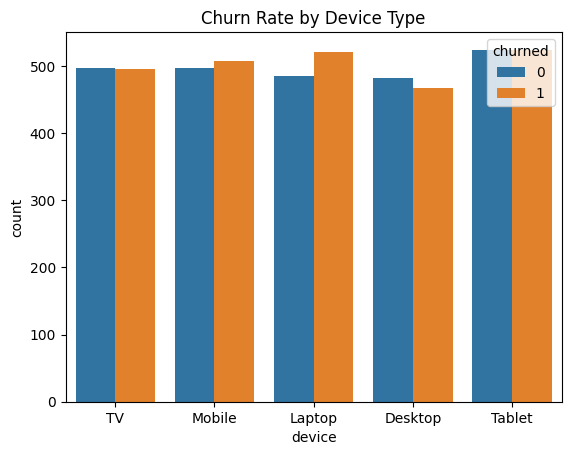

In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns

# Churn by Contract Type

sns.countplot(data=df, x='device', hue='churned') 
plt.title('Churn Rate by Device Type')

plt.show()

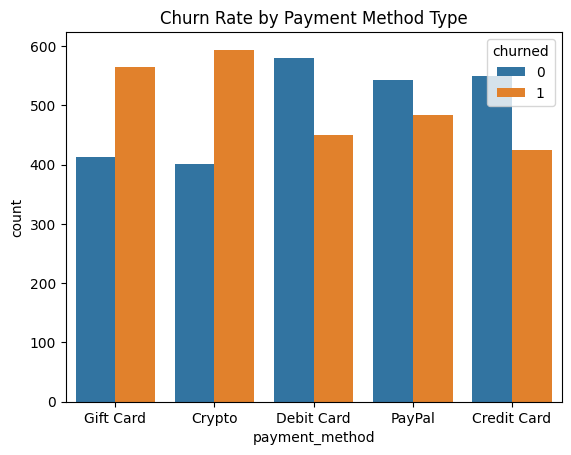

In [24]:
sns.countplot(data=df, x='payment_method', hue='churned') 
plt.title('Churn Rate by Payment Method Type')

plt.show()

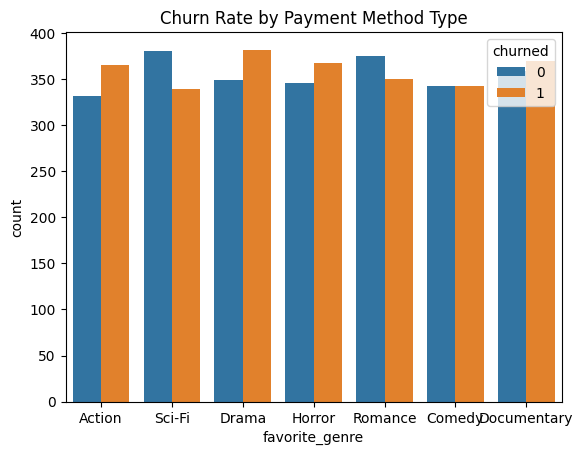

In [25]:
sns.countplot(data=df, x='favorite_genre', hue='churned')
plt.title('Churn Rate by Payment Method Type')

plt.show()

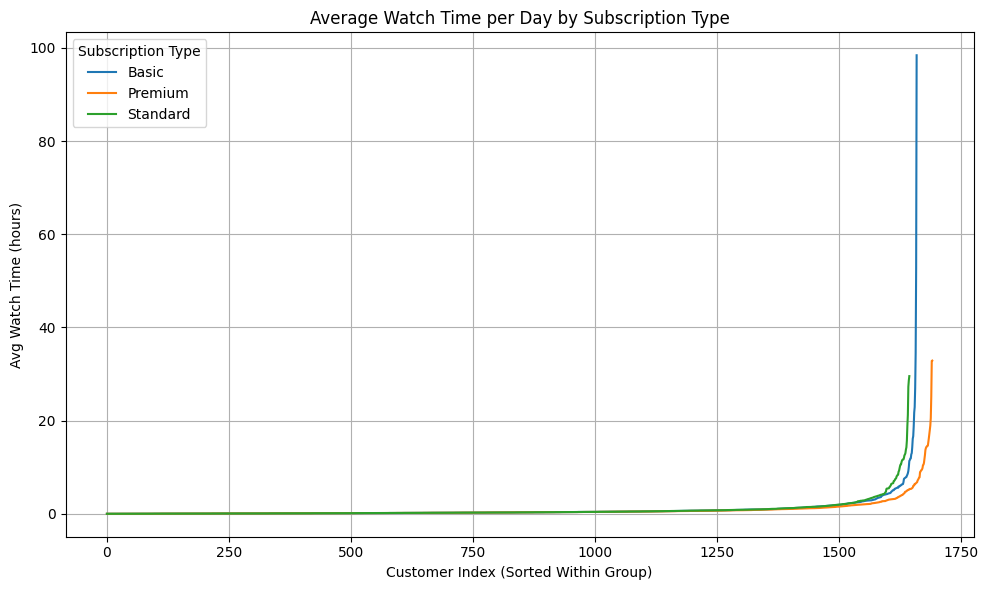

In [26]:
# Group by subscription type
plt.figure(figsize=(10, 6))

for sub_type, group_data in df.groupby('subscription_type'):
    sorted_avg = group_data['avg_watch_time_per_day'].sort_values().reset_index(drop=True)
    sns.lineplot(data=sorted_avg, label=sub_type)

plt.title("Average Watch Time per Day by Subscription Type")
plt.xlabel("Customer Index (Sorted Within Group)")
plt.ylabel("Avg Watch Time (hours)")
plt.legend(title="Subscription Type")
plt.grid(True)
plt.tight_layout()
plt.show()


<h1>Machine Learning</h1>

In [27]:
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


<h3>Logic Regression</h3>

In [28]:
# Example data preparation
X = df.drop('churned', axis=1)
y = df['churned']

# Identify column types
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Final pipeline
model_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and evaluate
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.896
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       498
           1       0.88      0.91      0.90       502

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



<h3>Random Forest Classifier</h3>

In [29]:
# Load and split your data
X = df.drop('churned', axis=1)
y = df['churned']

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing for numeric features
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Full pipeline with Random Forest
model_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.912
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       498
           1       0.87      0.96      0.92       502

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



<h3>Decision Trees</h3>

In [30]:
X = df.drop('churned', axis=1)
y = df['churned']

# Identify column types
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Numeric preprocessing
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Full pipeline with Decision Tree
model_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))  # you can tune max_depth
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.912
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       498
           1       0.93      0.90      0.91       502

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

